In [1]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

#Regression

In [3]:
df = pd.read_csv('melb_data.csv')
df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


In [4]:
df = df.dropna(axis=0,thresh=20)
df['YearBuilt'] = df['YearBuilt'].fillna(1995)
meanBuildingArea = df['BuildingArea'].sum()/df['BuildingArea'].count()
df['BuildingArea'] = df['BuildingArea'].fillna(meanBuildingArea)
df['CouncilArea'] = df['CouncilArea'].fillna(method='ffill')
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
6,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,4.0,2.0,0.0,245.0,210.0,1910.0,Yarra,-37.80240,144.99930,Northern Metropolitan,4019.0
7,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,2.0,1.0,2.0,256.0,107.0,1890.0,Yarra,-37.80600,144.99540,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13572,Watsonia,76 Kenmare St,2,h,650000.0,PI,Morrison,26/08/2017,14.5,3087.0,2.0,1.0,1.0,210.0,79.0,2006.0,Maribyrnong,-37.70657,145.07878,Northern Metropolitan,2329.0
13573,Werribee,5 Nuragi Ct,4,h,635000.0,S,hockingstuart,26/08/2017,14.7,3030.0,4.0,2.0,1.0,662.0,172.0,1980.0,Maribyrnong,-37.89327,144.64789,Western Metropolitan,16166.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,Maribyrnong,-37.85927,144.87904,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,Maribyrnong,-37.85908,144.89299,Western Metropolitan,6380.0


In [5]:
Y = df['Price']
X = df[[i for i in df.columns if i!='Price' and df[i].dtype in [np.int64, np.float64]]]
train_X, val_X, train_Y, val_Y = train_test_split(X, Y, random_state = 1)

Linear Regressor

In [6]:
lr = LinearRegression()
lr_model = lr.fit(train_X, train_Y)

In [7]:
lr_model.predict([train_X.loc[12496]])

array([729651.67206991])

In [8]:
train_Y.loc[12496]

797000.0

In [9]:
from sklearn.metrics import r2_score

In [10]:
y_pred = lr_model.predict(val_X)

In [11]:
r2_score(val_Y, y_pred)

0.5904013538058044

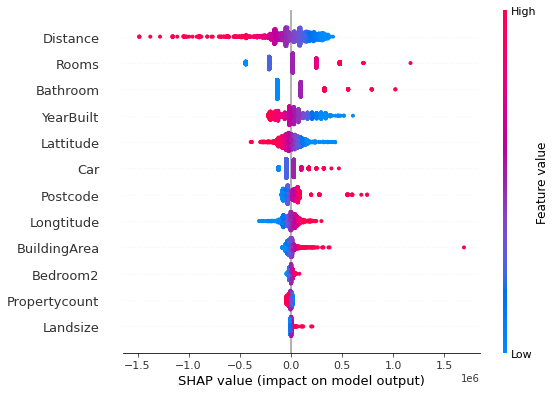

In [12]:
explainer = shap.LinearExplainer(lr_model, val_X)
shap_values = explainer.shap_values(val_X)
shap.summary_plot(shap_values, val_X)

XGBoost Regressor

In [13]:
xgbr = XGBRegressor()
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
val_X_scaled = scaler.fit_transform(val_X)
val_X_mean = scaler.mean_
val_X_std = scaler.var_**(1/2)

In [14]:
xgbr_model = xgbr.fit(train_X_scaled, train_Y)

[10:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [15]:
est = xgbr_model.predict(val_X_scaled)

In [16]:
r2_score(val_Y, est)

0.7550564829082795

In [17]:
xgbr_model.predict([train_X_scaled[1]])

array([2417909.5], dtype=float32)

In [18]:
train_Y.head()

5714     505000.0
8923    2450000.0
8626     485000.0
2566    1008000.0
2497     400000.0
Name: Price, dtype: float64

Passing 2083 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
 99%|===================| 2072/2083 [00:52<00:00]       

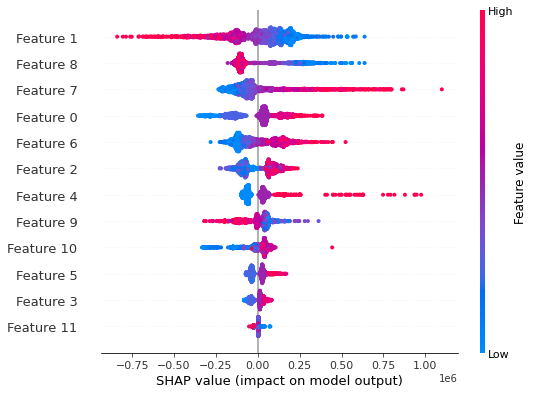

In [19]:
explainer = shap.TreeExplainer(xgbr_model, val_X_scaled)
shap_values = explainer.shap_values(val_X_scaled)
shap.summary_plot(shap_values, val_X_scaled)

#Classification

In [20]:
df2 = pd.read_csv('train.csv')
df2

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,payer_code_HM,payer_code_SP,payer_code_BC,medical_specialty_?,medical_specialty_InternalMedicine,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_Cardiology,diag_1_428,diag_1_414,diag_1_786,diag_2_276,diag_2_428,diag_2_250,diag_2_427,diag_3_250,diag_3_401,diag_3_276,diag_3_428,max_glu_serum_None,A1Cresult_None,metformin_No,repaglinide_No,nateglinide_No,chlorpropamide_No,glimepiride_No,acetohexamide_No,glipizide_No,glyburide_No,tolbutamide_No,pioglitazone_No,rosiglitazone_No,acarbose_No,miglitol_No,troglitazone_No,tolazamide_No,examide_No,citoglipton_No,insulin_No,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_No,diabetesMed_Yes,readmitted
0,14,41,0,11,0,0,0,6,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0
1,2,30,0,12,0,0,1,9,True,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,1
2,5,66,0,22,1,0,2,9,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
3,3,63,0,8,0,0,0,8,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
4,5,40,0,6,0,0,1,9,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2,85,0,12,0,0,0,9,True,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,0
24996,5,35,2,15,0,0,0,9,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
24997,3,10,1,23,1,0,0,4,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,1
24998,8,69,3,41,1,0,0,9,True,False,False,False,True,F

In [21]:
df2.isnull().sum()

time_in_hospital              0
num_lab_procedures            0
num_procedures                0
num_medications               0
number_outpatient             0
                             ..
metformin-rosiglitazone_No    0
metformin-pioglitazone_No     0
change_No                     0
diabetesMed_Yes               0
readmitted                    0
Length: 65, dtype: int64

In [22]:
for i in df2.columns:
  if df2[i].dtype == bool:
    df2[i] = df2[i] + 0
Y2 = df2['readmitted']
X2 = df2[[i for i in df2.columns if i!='readmitted']]
X2

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,payer_code_HM,payer_code_SP,payer_code_BC,medical_specialty_?,medical_specialty_InternalMedicine,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_Cardiology,diag_1_428,diag_1_414,diag_1_786,diag_2_276,diag_2_428,diag_2_250,diag_2_427,diag_3_250,diag_3_401,diag_3_276,diag_3_428,max_glu_serum_None,A1Cresult_None,metformin_No,repaglinide_No,nateglinide_No,chlorpropamide_No,glimepiride_No,acetohexamide_No,glipizide_No,glyburide_No,tolbutamide_No,pioglitazone_No,rosiglitazone_No,acarbose_No,miglitol_No,troglitazone_No,tolazamide_No,examide_No,citoglipton_No,insulin_No,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_No,diabetesMed_Yes
0,14,41,0,11,0,0,0,6,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2,30,0,12,0,0,1,9,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1
2,5,66,0,22,1,0,2,9,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,3,63,0,8,0,0,0,8,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,5,40,0,6,0,0,1,9,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2,85,0,12,0,0,0,9,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1
24996,5,35,2,15,0,0,0,9,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
24997,3,10,1,23,1,0,0,4,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1
24998,8,69,3,41,1,0,0,9,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1


In [23]:
train_X2, val_X2, train_Y2, val_Y2 = train_test_split(X2, Y2, random_state = 1)

Logistic Regression

In [24]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(train_X2, train_Y2)

In [25]:
rfc_model.predict_proba([train_X2.loc[21693]])

array([[0.82, 0.18]])

In [26]:
train_Y2[21693]

0

In [27]:
rfc_model.predict([train_X2.loc[21693]])

array([0])

In [28]:
y2_predict = rfc_model.predict(val_X2)
print(classification_report(val_Y2, y2_predict))

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3364
           1       0.61      0.47      0.53      2886

    accuracy                           0.62      6250
   macro avg       0.62      0.61      0.61      6250
weighted avg       0.62      0.62      0.61      6250



Confusion matrix, without normalization
[[2511  853]
 [1527 1359]]
Normalized confusion matrix
[[0.74643282 0.25356718]
 [0.52910603 0.47089397]]


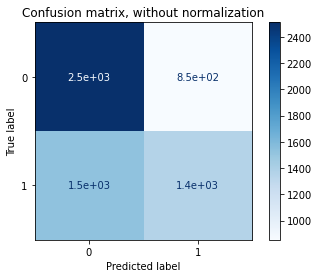

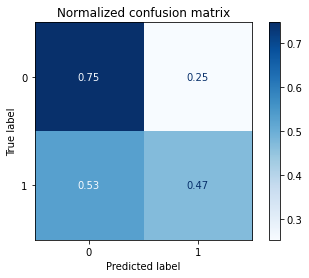

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rfc_model, val_X2, val_Y2,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

 96%|=================== | 192/200 [00:25<00:01]       

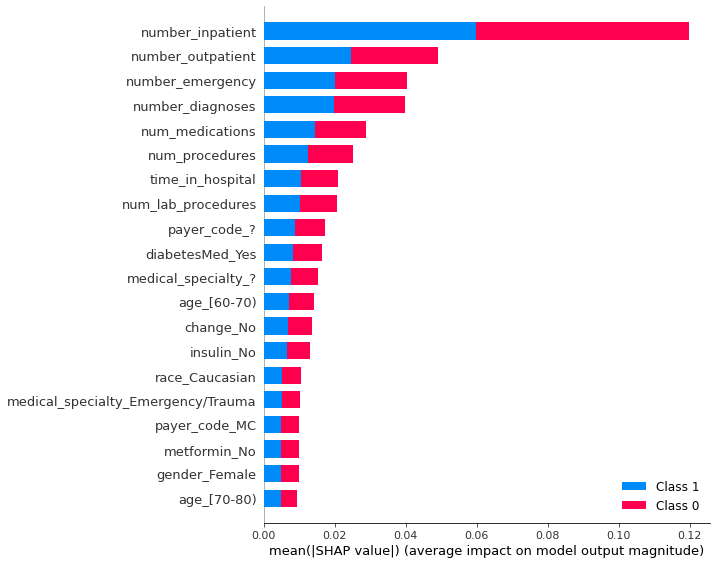

In [30]:
subset_to_explain = val_X2.iloc[0:100]
explainer = shap.TreeExplainer(rfc_model, subset_to_explain)
shap_values = explainer.shap_values(subset_to_explain)
shap.initjs()
shap.summary_plot(shap_values, subset_to_explain)

In [31]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], subset_to_explain)

SGD Classifier

In [32]:
sgdc = SGDClassifier()
sgdc_model = sgdc.fit(train_X2, train_Y2)

In [33]:
sgdc_model.predict([train_X2.loc[18060]])

array([0])

In [34]:
train_Y2.loc[18060]

0

In [35]:
pred_Y2 = sgdc_model.predict(val_X2)
print(classification_report(val_Y2, pred_Y2))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61      3364
           1       0.55      0.60      0.57      2886

    accuracy                           0.59      6250
   macro avg       0.59      0.59      0.59      6250
weighted avg       0.59      0.59      0.59      6250



Confusion matrix, without normalization
[[1983 1381]
 [1167 1719]]
Normalized confusion matrix
[[0.58947681 0.41052319]
 [0.4043659  0.5956341 ]]


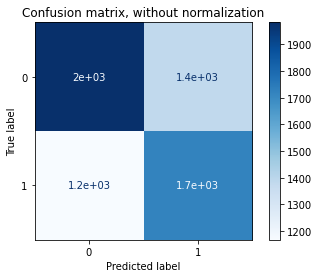

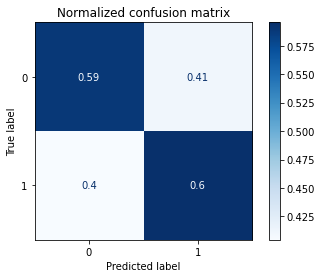

In [36]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(sgdc_model, val_X2, val_Y2,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

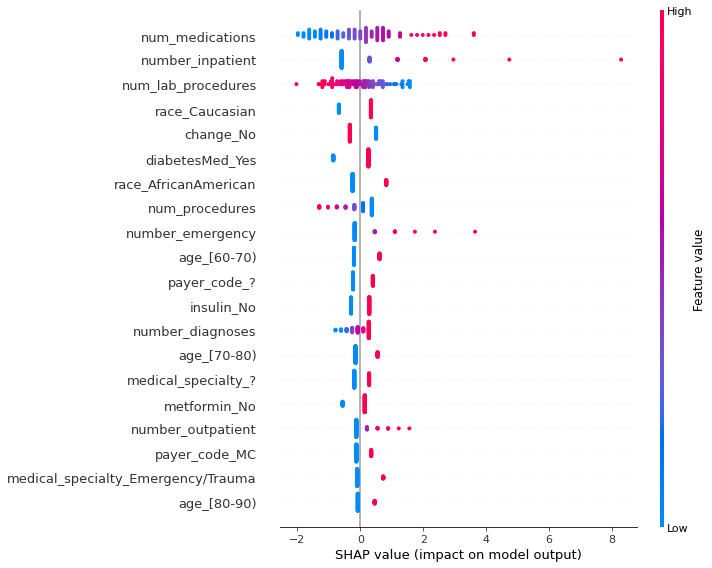

In [37]:
explainer = shap.LinearExplainer(sgdc_model, subset_to_explain)
shap_values = explainer.shap_values(subset_to_explain)
shap.initjs()
shap.summary_plot(shap_values, subset_to_explain)

SVC

In [38]:
svc = SVC()
train_X2_scaled = scaler.fit_transform(train_X2)
val_X2_scaled = scaler.fit_transform(val_X2)
svc_model = svc.fit(train_X2_scaled, train_Y2)

In [39]:
y2_pred = svc_model.predict(val_X2_scaled)

In [40]:
print(classification_report(val_Y2, y2_pred))

              precision    recall  f1-score   support

           0       0.62      0.79      0.69      3364
           1       0.64      0.43      0.51      2886

    accuracy                           0.62      6250
   macro avg       0.63      0.61      0.60      6250
weighted avg       0.63      0.62      0.61      6250



Confusion matrix, without normalization
[[2670  694]
 [1654 1232]]
Normalized confusion matrix
[[0.79369798 0.20630202]
 [0.57311157 0.42688843]]


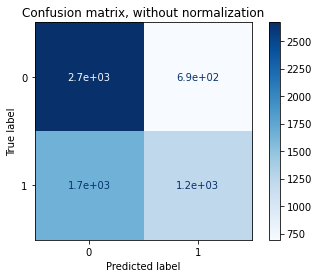

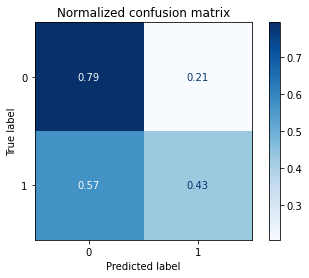

In [46]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc_model, val_X2_scaled, val_Y2,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
subset_to_explain_scaled = val_X2_scaled[0:100]
explainer = shap.KernelExplainer(svc_model.predict, subset_to_explain_scaled)
shap_values = explainer.shap_values(subset_to_explain_scaled)
shap.initjs()
shap.summary_plot(shap_values, subset_to_explain_scaled)

MLP Classifier

In [41]:
mlp = MLPClassifier(max_iter=2000)
mlp_model = mlp.fit(train_X2_scaled, train_Y2)

Confusion matrix, without normalization
[[2074 1290]
 [1352 1534]]
Normalized confusion matrix
[[0.61652794 0.38347206]
 [0.46846847 0.53153153]]


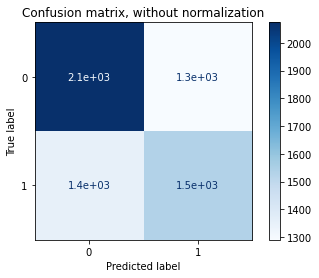

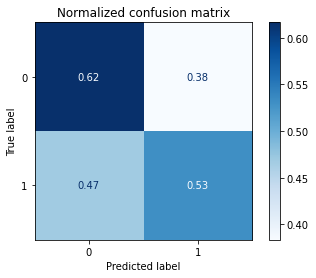

In [47]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(mlp_model, val_X2_scaled, val_Y2,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
subset_to_explain_scaled = val_X2_scaled[0:100]
explainer = shap.KernelExplainer(mlp_model.predict, subset_to_explain_scaled)
shap_values = explainer.shap_values(subset_to_explain_scaled)
shap.initjs()
shap.summary_plot(shap_values, subset_to_explain_scaled)

#Deep Neural Networks

Model Creation

In [44]:
#Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/12
469/469 [==============================] - 7s 15ms/step - loss: 2.2707 - accuracy: 0.1633 - val_loss: 2.2305 - val_accuracy: 0.3465
Epoch 2/12
469/469 [==============================] - 6s 14ms/step - loss: 2.2073 - accuracy: 0.2662 - val_loss: 2.1540 - val_accuracy: 0.4718
Epoch 3/12
469/469 [==============================] - 6s 14ms/step - loss: 2.1298 - accuracy: 0.3564 - val_loss: 2.0555 - val_accuracy: 0.5959
Epoch 4/12
469/469 [==============================] - 6s 14ms/step - loss: 2.0271 - accuracy: 0.4400 - val_loss: 1.9254 - val_accuracy: 0.6709
Epoch 5/12
469/469 [==============================] - 6s 14ms/step - loss: 1.8948 - accuracy: 0.5062 - val_loss: 1.7591 - val_accuracy: 0.7107
Epoch 6/12
469/469 [==============================] - 7s 14ms/step - loss: 1.7369 - accuracy: 0.5595 - val_loss: 1.5633 - val_accuracy: 0.7398
Epoc

SHAP Values

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


keras is no longer supported, please use tf.keras instead.


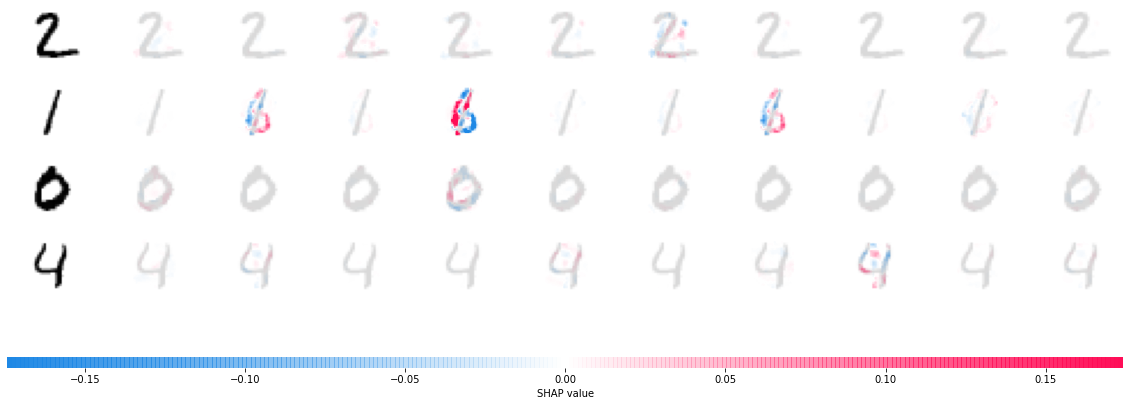

In [45]:
#Source: https://github.com/slundberg/shap

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])